In [34]:
import pandas as pd
import numpy as np
import pm4py
from pm4py.objects.log.util import sorting
from scipy.stats import wasserstein_distance
from sklearn import preprocessing

from log_distance_measures.config import EventLogIDs, AbsoluteTimestampType, discretize_to_hour
from log_distance_measures.control_flow_log_distance import control_flow_log_distance
from log_distance_measures.n_gram_distribution import n_gram_distribution_distance
from log_distance_measures.absolute_event_distribution import absolute_event_distribution_distance
from log_distance_measures.case_arrival_distribution import case_arrival_distribution_distance
from log_distance_measures.circadian_event_distribution import circadian_event_distribution_distance
from log_distance_measures.relative_event_distribution import relative_event_distribution_distance
from log_distance_measures.work_in_progress import work_in_progress_distance
from log_distance_measures.cycle_time_distribution import cycle_time_distribution_distance

import warnings
warnings.filterwarnings("ignore")

In [35]:
import re
def extract_first_float(cell):
    if isinstance(cell, str):
        # Use regular expression to extract the first float and the value in brackets
        match = re.match(r'(\d+\.\d+)(?: \((\d+\.\d+)\))?', cell)
        if match:
            return float(match.group(1)), (match.group(2)) if match.group(2) else ''
        else:
            return float('inf'), ''
    else:
        return cell, ''

In [36]:
def highlight_min_max(s):
    """
    Highlight the minimum value in green and the maximum value in red for each column.
    """
    is_min = s == s.min()
    is_max = s == s.max()
    min_max_style = ['background-color: green' if v else '' for v in is_min]
    for i, v in enumerate(is_max):
        if v:
            min_max_style[i] = 'background-color: red'
    return min_max_style

In [37]:
def align_column_names(df):
    if 'case:concept:name' in df.columns:
        df = df.rename(columns={'case:concept:name': 'case_id'})
    elif 'caseid' in df.columns:
        df = df.rename(columns={'caseid': 'case_id'})
    if 'Activity' in df.columns:
        df = df.rename(columns={'Activity': 'activity'})
    elif 'activity_name' in df.columns:
        df = df.rename(columns={'activity_name': 'activity'})
    elif 'task' in df.columns:
        df = df.rename(columns={'task': 'activity'})
    elif 'concept:name' in df.columns:
        df = df.rename(columns={'concept:name': 'activity'})
    if 'Resource' in df.columns:
        df = df.rename(columns={'Resource': 'resource'})
    elif 'user' in df.columns:
        df = df.rename(columns={'user': 'resource'})
    elif 'agent' in df.columns:
        if 'resource' in df.columns:
            df = df.drop(['resource'], axis=1)
        df = df.rename(columns={'agent': 'resource'})
    elif 'org:resource' in df.columns:
        df = df.rename(columns={'org:resource': 'resource'})
    if 'start_timestamp' in df.columns:
        df = df.rename(columns={'start_timestamp': 'start_time'})
    if 'end_timestamp' in df.columns:
        df = df.rename(columns={'end_timestamp': 'end_time'})
    # for SIMOD simulated logs
    if 'start_time' in df.columns:
        df = df.rename(columns={'start_time': 'start_time'})
    if 'end_time' in df.columns:
        df = df.rename(columns={'end_time': 'end_time'})
    if 'start:timestamp' in df.columns:
        df = df.rename(columns={'start:timestamp': 'start_time'})
    if 'time:timestamp' in df.columns:
        df = df.rename(columns={'time:timestamp': 'end_time'})
    return df

In [38]:
import numpy as np
import pandas as pd
from scipy.linalg import norm

def compute_transition_matrix(event_log: pd.DataFrame, case_id_col: str, resource_col: str) -> pd.DataFrame:
    """
    Compute the transition matrix of resources from an event log.
    
    :param event_log: Event log as a pandas DataFrame.
    :param case_id_col: Column name for case IDs in the log.
    :param resource_col: Column name for resources in the log.
    :return: A pandas DataFrame representing the transition matrix.
    """
    # Convert case IDs and resources to strings to avoid numeric index issues
    event_log = event_log.copy()
    event_log[case_id_col] = event_log[case_id_col].astype(str)
    event_log[resource_col] = event_log[resource_col].astype(str)

    # Sort events within each case by timestamp
    event_log = event_log.sort_values(by=[case_id_col, 'start_time', 'end_time']).reset_index(drop=True)
    
    # Extract transitions (resource pairs) as tuples
    transitions = []
    for _, case_events in event_log.groupby(case_id_col):
        resources = case_events[resource_col].values.tolist()
        # Only add transitions if there are at least 2 events
        if len(resources) >= 2:
            transitions.extend([(str(resources[i]), str(resources[i + 1])) 
                              for i in range(len(resources) - 1)])
    
    # If no transitions found, return empty matrix
    if not transitions:
        return pd.DataFrame()
    
    # Create transition matrix
    unique_resources = sorted(set(r for pair in transitions for r in pair))
    transition_matrix = pd.DataFrame(0, index=unique_resources, columns=unique_resources)
    
    # Count transitions
    for from_res, to_res in transitions:
        transition_matrix.loc[from_res, to_res] += 1
    
    # Normalize rows to probabilities
    row_sums = transition_matrix.sum(axis=1)
    # Avoid division by zero by replacing 0 sums with 1
    row_sums = row_sums.replace(0, 1)
    transition_matrix = transition_matrix.div(row_sums, axis=0)
    
    return transition_matrix

def transition_matrix_distance(original_log: pd.DataFrame, simulated_log: pd.DataFrame,
                               case_id_col: str, resource_col: str) -> float:
    """
    Compute the distance between resource transition matrices of two event logs.
    
    :param original_log: Original event log as a pandas DataFrame.
    :param simulated_log: Simulated event log as a pandas DataFrame.
    :param case_id_col: Column name for case IDs in the logs.
    :param resource_col: Column name for resources in the logs.
    :return: Frobenius norm of the difference between the two transition matrices.
    """
    # Compute transition matrices
    original_matrix = compute_transition_matrix(original_log, case_id_col, resource_col)
    simulated_matrix = compute_transition_matrix(simulated_log, case_id_col, resource_col)
    
    # Align matrices to have the same resources
    all_resources = sorted(set(original_matrix.index).union(set(simulated_matrix.index)))
    original_matrix = original_matrix.reindex(index=all_resources, columns=all_resources, fill_value=0)
    simulated_matrix = simulated_matrix.reindex(index=all_resources, columns=all_resources, fill_value=0)
    
    # Compute Frobenius norm of the difference
    distance = norm(original_matrix.values - simulated_matrix.values, ord='fro')
    return distance

In [39]:
def main_(log_paths, name_experiments):
    def perform_evauluation(all_metrics, PATH_SIMULATED_LOG, test_log):
        for i in range(10):
            # print(f"Evaluate simulation {i}")
            path_simulated_file = PATH_SIMULATED_LOG + '/simulated_log_' + str(i) + '.csv'
            # read simulated log and align column names
            simulated_log = pd.read_csv(path_simulated_file)
            simulated_log = align_column_names(simulated_log)
            # print(simulated_log)
            # print("########")
            # print(simulated_log[event_log_ids.activity].unique())
            simulated_log[event_log_ids.start_time] = pd.to_datetime(simulated_log[event_log_ids.start_time], utc=True, format='mixed')
            simulated_log[event_log_ids.end_time] = pd.to_datetime(simulated_log[event_log_ids.end_time], utc=True, format='mixed')

            # Call passing the event logs, and its column ID mappings
            ngd = n_gram_distribution_distance(test_log, event_log_ids, simulated_log, event_log_ids, n=3)
            all_metrics['NGD'].append(ngd)

            # Call passing the event logs, its column ID mappings, timestamp type, and discretize function
            aedd = absolute_event_distribution_distance(
                test_log, event_log_ids,  # First event log and its column id mappings
                simulated_log, event_log_ids,  # Second event log and its column id mappings
                discretize_type=AbsoluteTimestampType.BOTH,  # Type of timestamp distribution (consider start times and/or end times)
                discretize_event=discretize_to_hour  # Function to discretize the absolute seconds of each timestamp (default by hour)
            )
            all_metrics['AEDD'].append(aedd)

            # cadd = case_arrival_distribution_distance(
            #     test_log, event_log_ids,  # First event log and its column id mappings
            #     simulated_log, event_log_ids,  # Second event log and its column id mappings
            #     discretize_event=discretize_to_hour  # Function to discretize each timestamp (default by hour)
            # )
            # all_metrics['CADD'].append(cadd)

            cedd = circadian_event_distribution_distance(
                test_log, event_log_ids,  # First event log and its column id mappings
                simulated_log, event_log_ids,  # Second event log and its column id mappings
                discretize_type=AbsoluteTimestampType.BOTH  # Consider both start/end timestamps of each activity instance
            )
            all_metrics['CEDD'].append(cedd)

            redd = relative_event_distribution_distance(
                test_log, event_log_ids,  # First event log and its column id mappings
                simulated_log, event_log_ids,  # Second event log and its column id mappings
                discretize_type=AbsoluteTimestampType.BOTH,  # Type of timestamp distribution (consider start times and/or end times)
                discretize_event=discretize_to_hour  # Function to discretize the absolute seconds of each timestamp (default by hour)
            )
            all_metrics['REDD'].append(redd)


            ctdd = cycle_time_distribution_distance(
                test_log, event_log_ids,  # First event log and its column id mappings
                simulated_log, event_log_ids,  # Second event log and its column id mappings
                bin_size=pd.Timedelta(hours=1)  # Bins of 1 hour
            )
            all_metrics['CTDD'].append(ctdd)

            rtmd = transition_matrix_distance(test_log, simulated_log, 'case_id', 'resource')
            all_metrics['RTMD'].append(rtmd)

        return all_metrics
    
    number_evaluations = len(log_paths)

    # Set event log column ID mapping
    event_log_ids = EventLogIDs(  # These values are stored in DEFAULT_CSV_IDS
        case="case_id",
        activity="activity",
        start_time="start_time",
        end_time="end_time",
        resource='resource'
    )

    index_names = name_experiments
    results_df = pd.DataFrame(index=index_names)
    mean_results = pd.DataFrame(index=index_names)

    for experiment in range(number_evaluations):
        # Read and transform time attributes
        test_log = pd.read_csv(log_paths[experiment][0])
        test_log = align_column_names(test_log)
        test_log[event_log_ids.start_time] = pd.to_datetime(test_log[event_log_ids.start_time], utc=True, format='mixed')
        test_log[event_log_ids.end_time] = pd.to_datetime(test_log[event_log_ids.end_time], utc=True, format='mixed')

        PATH_SIMULATED_LOG = log_paths[experiment][1]

        all_metrics = {
            'NGD': [],
            'AEDD': [],
            # 'CADD': [],
            'CEDD': [],
            'REDD': [],
            'CTDD': [],
            'RTMD': [],
        }

        all_metrics = perform_evauluation(all_metrics, PATH_SIMULATED_LOG, test_log)

        mean_results.loc[index_names[experiment], 'N-Gram Distribution Distance'] = round(np.mean(all_metrics['NGD']), 3)
        mean_results.loc[index_names[experiment], 'Absolute Event Distribution Distance'] = round(np.mean(all_metrics['AEDD']), 3)
        # mean_results.loc[index_names[experiment], 'Case Arrival Distribution Distance'] = round(np.mean(all_metrics['CADD']), 3)
        mean_results.loc[index_names[experiment], 'Circadian Event Distribution Distance'] = round(np.mean(all_metrics['CEDD']), 3)
        mean_results.loc[index_names[experiment], 'Relative Event Distribution Distance'] = round(np.mean(all_metrics['REDD']), 3)
        mean_results.loc[index_names[experiment], 'Cycle Time Distribution Distance'] = round(np.mean(all_metrics['CTDD']), 3)
        mean_results.loc[index_names[experiment], 'Resource Transition Matrix Distance'] = round(np.mean(all_metrics['RTMD']), 3)

    

        results_df.loc[index_names[experiment], 'N-Gram Distribution Distance'] = f"{round(np.mean(all_metrics['NGD']), 3)} ({round(np.std(all_metrics['NGD']), 3)})"
        results_df.loc[index_names[experiment], 'Absolute Event Distribution Distance'] = f"{round(np.mean(all_metrics['AEDD']), 3)} ({round(np.std(all_metrics['AEDD']), 3)})"
        # results_df.loc[index_names[experiment], 'Case Arrival Distribution Distance'] = f"{round(np.mean(all_metrics['CADD']), 3)} ({round(np.std(all_metrics['CADD']), 3)})"
        results_df.loc[index_names[experiment], 'Circadian Event Distribution Distance'] = f"{round(np.mean(all_metrics['CEDD']), 3)} ({round(np.std(all_metrics['CEDD']), 3)})"
        results_df.loc[index_names[experiment], 'Relative Event Distribution Distance'] = f"{round(np.mean(all_metrics['REDD']), 3)} ({round(np.std(all_metrics['REDD']), 3)})"
        results_df.loc[index_names[experiment], 'Cycle Time Distribution Distance'] = f"{round(np.mean(all_metrics['CTDD']), 3)} ({round(np.std(all_metrics['CTDD']), 3)})"
        results_df.loc[index_names[experiment], 'Resource Transition Matrix Distance'] = f"{round(np.mean(all_metrics['RTMD']), 3)} ({round(np.std(all_metrics['RTMD']), 3)})"
    return mean_results, results_df


### Loan Application

In [11]:
PATH_TEST_LOG_MAS = '../simulated_data/LoanApp.csv/autonomous_smap_smap/test_preprocessed.csv'
PATH_SIMULATED_LOG_MAS = '../simulated_data/LoanApp.csv/autonomous_smap_smap'

PATH_TEST_LOG_LSTM = '../simulated_data/LoanApp.csv/orchestrated_lstm/test_preprocessed.csv'
PATH_SIMULATED_LOG_LSTM = '../simulated_data/LoanApp.csv/orchestrated_lstm'

PATH_TEST_LOG_LSTM_local = '../simulated_data/LoanApp.csv/orchestrated_lstm_local2/test_preprocessed.csv'
PATH_SIMULATED_LOG_LSTM_local = '../simulated_data/LoanApp.csv/orchestrated_lstm_local2'

log_paths = [
    [PATH_TEST_LOG_MAS, PATH_SIMULATED_LOG_MAS],
    [PATH_TEST_LOG_LSTM, PATH_SIMULATED_LOG_LSTM],
    [PATH_TEST_LOG_LSTM_local, PATH_SIMULATED_LOG_LSTM_local],
]

name_experiments = ['AM', 'LSTM', 'LSTM_local']

mean_results, results_df = main_(log_paths, name_experiments)
results_df

,N-Gram Distribution Distance,Absolute Event Distribution Distance,Circadian Event Distribution Distance,Relative Event Distribution Distance,Cycle Time Distribution Distance
AM,0.647 (0.006),13.216 (6.22),0.285 (0.025),7.296 (0.911),3.028 (0.506)
LSTM,0.08 (0.014),3.043 (0.876),0.243 (0.048),2.057 (0.651),2.894 (0.869)
LSTM_local,0.139 (0.016),3.478 (0.999),0.234 (0.032),2.719 (0.614),3.455 (0.978)


## P2P

In [12]:
PATH_TEST_LOG_MAS = '../simulated_data/P2P/autonomous_smap_smap/test_preprocessed.csv'
PATH_SIMULATED_LOG_MAS = '../simulated_data/P2P/autonomous_smap_smap'

PATH_TEST_LOG_LSTM = '../simulated_data/P2P/orchestrated_lstm/test_preprocessed.csv'
PATH_SIMULATED_LOG_LSTM = '../simulated_data/P2P/orchestrated_lstm'

PATH_TEST_LOG_LSTM_local = '../simulated_data/P2P/orchestrated_lstm_local2/test_preprocessed.csv'
PATH_SIMULATED_LOG_LSTM_local = '../simulated_data/P2P/orchestrated_lstm_local2'

log_paths = [
    [PATH_TEST_LOG_MAS, PATH_SIMULATED_LOG_MAS],
    [PATH_TEST_LOG_LSTM, PATH_SIMULATED_LOG_LSTM],
    [PATH_TEST_LOG_LSTM_local, PATH_SIMULATED_LOG_LSTM_local],
]   

name_experiments = ['AM', 'LSTM', 'LSTM_local']

mean_results, results_df = main_(log_paths, name_experiments)
results_df

,N-Gram Distribution Distance,Absolute Event Distribution Distance,Circadian Event Distribution Distance,Relative Event Distribution Distance,Cycle Time Distribution Distance
AM,0.899 (0.013),1295.878 (12.109),1.796 (0.277),827.481 (9.202),664.956 (7.958)
LSTM,0.306 (0.019),1222.752 (5.22),1.422 (0.181),730.29 (5.599),574.817 (6.279)
LSTM_local,0.299 (0.013),1193.583 (6.319),1.134 (0.134),727.042 (6.706),559.332 (6.263)


### Confidential_1000

In [14]:
PATH_TEST_LOG_MAS = '../simulated_data/Confidential_1000/autonomous_smap_smap/test_preprocessed.csv'
PATH_SIMULATED_LOG_MAS = '../simulated_data/Confidential_1000/autonomous_smap_smap'

PATH_TEST_LOG_LSTM = '../simulated_data/Confidential_1000/autonomous_lstm/test_preprocessed.csv'
PATH_SIMULATED_LOG_LSTM = '../simulated_data/Confidential_1000/autonomous_lstm'

PATH_TEST_LOG_LSTM_local = '../simulated_data/Confidential_1000/autonomous_lstm_local2/test_preprocessed.csv'
PATH_SIMULATED_LOG_LSTM_local = '../simulated_data/Confidential_1000/autonomous_lstm_local2'

log_paths = [
    [PATH_TEST_LOG_MAS, PATH_SIMULATED_LOG_MAS],
    [PATH_TEST_LOG_LSTM, PATH_SIMULATED_LOG_LSTM],
    [PATH_TEST_LOG_LSTM_local, PATH_SIMULATED_LOG_LSTM_local],
]

name_experiments = ['AM', 'LSTM', 'LSTM_local']

mean_results, results_df = main_(log_paths, name_experiments)
results_df

,N-Gram Distribution Distance,Absolute Event Distribution Distance,Circadian Event Distribution Distance,Relative Event Distribution Distance,Cycle Time Distribution Distance
AM,0.804 (0.004),152.964 (8.996),6.032 (1.136),9.485 (0.517),7.563 (0.637)
LSTM,0.241 (0.01),118.163 (9.407),2.509 (0.284),25.427 (8.917),41.335 (14.375)
LSTM_local,0.295 (0.006),116.068 (14.531),3.018 (0.267),26.378 (11.589),42.484 (17.143)


In [15]:
# PATH_TEST_LOG_MAS = '../simulated_data/Confidential_2000/autonomous_smap_smap/test_preprocessed.csv'
# PATH_SIMULATED_LOG_MAS = '../simulated_data/Confidential_2000/autonomous_smap_smap'

PATH_TEST_LOG_LSTM = '../simulated_data/Confidential_2000/autonomous_lstm/test_preprocessed.csv'
PATH_SIMULATED_LOG_LSTM = '../simulated_data/Confidential_2000/autonomous_lstm'

PATH_TEST_LOG_LSTM_local = '../simulated_data/Confidential_2000/autonomous_lstm_local2/test_preprocessed.csv'
PATH_SIMULATED_LOG_LSTM_local = '../simulated_data/Confidential_2000/autonomous_lstm_local2'

log_paths = [
    # [PATH_TEST_LOG_MAS, PATH_SIMULATED_LOG_MAS],
    [PATH_TEST_LOG_LSTM, PATH_SIMULATED_LOG_LSTM],
    [PATH_TEST_LOG_LSTM_local, PATH_SIMULATED_LOG_LSTM_local],
]

name_experiments = ['LSTM', 'LSTM_local']

mean_results, results_df = main_(log_paths, name_experiments)
results_df

,N-Gram Distribution Distance,Absolute Event Distribution Distance,Circadian Event Distribution Distance,Relative Event Distribution Distance,Cycle Time Distribution Distance
LSTM,0.289 (0.011),195.661 (5.46),2.775 (1.006),14.751 (5.681),26.185 (8.915)
LSTM_local,0.279 (0.007),202.001 (17.626),2.909 (1.046),46.142 (18.69),78.79 (26.707)


In [16]:
PATH_TEST_LOG_MAS = '../simulated_data/BPIC_2012_W/autonomous_smap_smap/test_preprocessed.csv'
PATH_SIMULATED_LOG_MAS = '../simulated_data/BPIC_2012_W/autonomous_smap_smap'

PATH_TEST_LOG_LSTM = '../simulated_data/BPIC_2012_W/orchestrated_lstm/test_preprocessed.csv'
PATH_SIMULATED_LOG_LSTM = '../simulated_data/BPIC_2012_W/orchestrated_lstm'

PATH_TEST_LOG_LSTM_local = '../simulated_data/BPIC_2012_W/orchestrated_lstm_local2/test_preprocessed.csv'
PATH_SIMULATED_LOG_LSTM_local = '../simulated_data/BPIC_2012_W/orchestrated_lstm_local2'

log_paths = [
    [PATH_TEST_LOG_MAS, PATH_SIMULATED_LOG_MAS],
    [PATH_TEST_LOG_LSTM, PATH_SIMULATED_LOG_LSTM],
    [PATH_TEST_LOG_LSTM_local, PATH_SIMULATED_LOG_LSTM_local],
]   

name_experiments = ['AM', 'LSTM', 'LSTM_local']

mean_results, results_df = main_(log_paths, name_experiments)
results_df

,N-Gram Distribution Distance,Absolute Event Distribution Distance,Circadian Event Distribution Distance,Relative Event Distribution Distance,Cycle Time Distribution Distance
AM,0.302 (0.007),80.95 (7.652),1.966 (0.071),79.483 (4.223),115.238 (2.889)
LSTM,0.166 (0.007),77.206 (8.512),1.831 (0.094),41.02 (6.838),72.984 (4.12)
LSTM_local,0.277 (0.019),206.02 (34.72),1.798 (0.059),160.213 (35.587),114.262 (11.522)


In [32]:
PATH_TEST_LOG_MAS = '../simulated_data/BPIC_2017_W/autonomous_smap_smap/test_preprocessed.csv'
PATH_SIMULATED_LOG_MAS = '../simulated_data/BPIC_2017_W/autonomous_smap_smap'

PATH_TEST_LOG_LSTM = '../simulated_data/BPIC_2017_W/autonomous_lstm/test_preprocessed.csv'
PATH_SIMULATED_LOG_LSTM = '../simulated_data/BPIC_2017_W/autonomous_lstm'

PATH_TEST_LOG_LSTM_local = '../simulated_data/BPIC_2017_W/autonomous_lstm_local2/test_preprocessed.csv'
PATH_SIMULATED_LOG_LSTM_local = '../simulated_data/BPIC_2017_W/autonomous_lstm_local2'

log_paths = [
    [PATH_TEST_LOG_MAS, PATH_SIMULATED_LOG_MAS],
    [PATH_TEST_LOG_LSTM, PATH_SIMULATED_LOG_LSTM],
    [PATH_TEST_LOG_LSTM_local, PATH_SIMULATED_LOG_LSTM_local],
]   

name_experiments = ['AM', 'LSTM', 'LSTM_local']

mean_results, results_df = main_(log_paths, name_experiments)
results_df

,N-Gram Distribution Distance,Absolute Event Distribution Distance,Circadian Event Distribution Distance,Relative Event Distribution Distance,Cycle Time Distribution Distance
AM,0.233 (0.002),180.37 (2.78),2.374 (0.019),29.075 (2.602),28.768 (1.907)
LSTM,0.188 (0.003),233.481 (3.087),2.387 (0.012),37.585 (1.245),34.832 (1.432)
LSTM_local,0.185 (0.002),241.444 (1.94),2.392 (0.017),50.825 (2.009),48.335 (2.343)


In [18]:
PATH_TEST_LOG_MAS = '../simulated_data/ConsultaDataMining/autonomous_smap_smap/test_preprocessed.csv'
PATH_SIMULATED_LOG_MAS = '../simulated_data/ConsultaDataMining/autonomous_smap_smap'

PATH_TEST_LOG_LSTM = '../simulated_data/ConsultaDataMining/orchestrated_lstm/test_preprocessed.csv'
PATH_SIMULATED_LOG_LSTM = '../simulated_data/ConsultaDataMining/orchestrated_lstm'

PATH_TEST_LOG_LSTM_local = '../simulated_data/ConsultaDataMining/orchestrated_lstm_local2/test_preprocessed.csv'
PATH_SIMULATED_LOG_LSTM_local = '../simulated_data/ConsultaDataMining/orchestrated_lstm_local2'

log_paths = [
    [PATH_TEST_LOG_MAS, PATH_SIMULATED_LOG_MAS],
    [PATH_TEST_LOG_LSTM, PATH_SIMULATED_LOG_LSTM],
    [PATH_TEST_LOG_LSTM_local, PATH_SIMULATED_LOG_LSTM_local],
]   

name_experiments = ['AM', 'LSTM', 'LSTM_local']

mean_results, results_df = main_(log_paths, name_experiments)
results_df

,N-Gram Distribution Distance,Absolute Event Distribution Distance,Circadian Event Distribution Distance,Relative Event Distribution Distance,Cycle Time Distribution Distance
AM,0.76 (0.014),328.956 (2.196),5.085 (0.219),25.444 (1.324),74.638 (1.198)
LSTM,0.404 (0.015),278.781 (1.978),6.048 (0.28),24.514 (0.981),71.675 (2.101)
LSTM_local,0.471 (0.025),315.989 (3.832),6.942 (0.29),23.014 (1.584),67.894 (2.221)


In [20]:
PATH_TEST_LOG_MAS = '../simulated_data/cvs_pharmacy/autonomous_smap_smap/test_preprocessed.csv'
PATH_SIMULATED_LOG_MAS = '../simulated_data/cvs_pharmacy/autonomous_smap_smap'

PATH_TEST_LOG_LSTM = '../simulated_data/cvs_pharmacy/orchestrated_lstm/test_preprocessed.csv'
PATH_SIMULATED_LOG_LSTM = '../simulated_data/cvs_pharmacy/orchestrated_lstm'

PATH_TEST_LOG_LSTM_local = '../simulated_data/cvs_pharmacy/orchestrated_lstm_local2/test_preprocessed.csv'
PATH_SIMULATED_LOG_LSTM_local = '../simulated_data/cvs_pharmacy/orchestrated_lstm_local2'

log_paths = [
    [PATH_TEST_LOG_MAS, PATH_SIMULATED_LOG_MAS],
    [PATH_TEST_LOG_LSTM, PATH_SIMULATED_LOG_LSTM],
    [PATH_TEST_LOG_LSTM_local, PATH_SIMULATED_LOG_LSTM_local],
]   

name_experiments = ['AM', 'LSTM', 'LSTM_local']

mean_results, results_df = main_(log_paths, name_experiments)
results_df

,N-Gram Distribution Distance,Absolute Event Distribution Distance,Circadian Event Distribution Distance,Relative Event Distribution Distance,Cycle Time Distribution Distance
AM,0.852 (0.002),117.977 (1.384),7.571 (0.026),110.996 (1.241),196.818 (2.618)
LSTM,0.101 (0.006),100.745 (1.361),7.588 (0.037),94.482 (1.5),119.236 (1.991)
LSTM_local,0.113 (0.004),98.176 (0.972),7.564 (0.028),90.465 (0.981),113.823 (2.225)


In [21]:
PATH_TEST_LOG_MAS = '../simulated_data/Production/autonomous_smap_smap/test_preprocessed.csv'
PATH_SIMULATED_LOG_MAS = '../simulated_data/Production/autonomous_smap_smap'

PATH_TEST_LOG_LSTM = '../simulated_data/Production/orchestrated_lstm/test_preprocessed.csv'
PATH_SIMULATED_LOG_LSTM = '../simulated_data/Production/orchestrated_lstm'

PATH_TEST_LOG_LSTM_local = '../simulated_data/Production/orchestrated_lstm_local2/test_preprocessed.csv'
PATH_SIMULATED_LOG_LSTM_local = '../simulated_data/Production/orchestrated_lstm_local2'

log_paths = [
    [PATH_TEST_LOG_MAS, PATH_SIMULATED_LOG_MAS],
    [PATH_TEST_LOG_LSTM, PATH_SIMULATED_LOG_LSTM],
    [PATH_TEST_LOG_LSTM_local, PATH_SIMULATED_LOG_LSTM_local],
]   

name_experiments = ['AM', 'LSTM', 'LSTM_local']

mean_results, results_df = main_(log_paths, name_experiments)
results_df

,N-Gram Distribution Distance,Absolute Event Distribution Distance,Circadian Event Distribution Distance,Relative Event Distribution Distance,Cycle Time Distribution Distance
AM,0.733 (0.022),92.835 (7.505),5.989 (0.419),47.648 (5.541),64.486 (4.077)
LSTM,0.57 (0.019),100.853 (11.051),5.483 (0.738),34.618 (9.813),24.8 (9.469)
LSTM_local,0.826 (0.022),81.037 (11.971),5.961 (0.783),26.952 (5.655),20.032 (7.286)


## Synthetic Log

In [43]:
PATH_TEST_LOG_MAS_orchestrated = '../simulated_data/synthetic_log_calendars/orchestrated/test_preprocessed.csv'
PATH_SIMULATED_LOG_MAS_orchestrated = '../simulated_data/synthetic_log_calendars/orchestrated'

PATH_TEST_LOG_MAS_autonomous = '../simulated_data/synthetic_log_calendars/autonomous/test_preprocessed.csv'
PATH_SIMULATED_LOG_MAS_autonomous = '../simulated_data/synthetic_log_calendars/autonomous'

log_paths = [
    [PATH_TEST_LOG_MAS_orchestrated, PATH_SIMULATED_LOG_MAS_orchestrated],
    [PATH_TEST_LOG_MAS_autonomous, PATH_SIMULATED_LOG_MAS_autonomous],
]

name_experiments = ['orchestrated', 'autonomous']

mean_results, results_df = main_(log_paths, name_experiments)
results_df

,N-Gram Distribution Distance,Absolute Event Distribution Distance,Circadian Event Distribution Distance,Relative Event Distribution Distance,Cycle Time Distribution Distance,Resource Transition Matrix Distance
orchestrated,0.022 (0.008),125.103 (1.743),0.182 (0.005),1.551 (0.085),2.898 (0.368),2.314 (0.029)
autonomous,0.007 (0.005),100.814 (0.425),0.18 (0.011),0.988 (0.154),2.069 (0.444),1.326 (0.011)


In [46]:
PATH_TEST_LOG_MAS_orchestrated = '../simulated_data/synthetic_log_calendars_2/orchestrated/test_preprocessed.csv'
PATH_SIMULATED_LOG_MAS_orchestrated = '../simulated_data/synthetic_log_calendars_2/orchestrated'

PATH_TEST_LOG_MAS_autonomous = '../simulated_data/synthetic_log_calendars_2/autonomous/test_preprocessed.csv'
PATH_SIMULATED_LOG_MAS_autonomous = '../simulated_data/synthetic_log_calendars_2/autonomous'

log_paths = [
    [PATH_TEST_LOG_MAS_orchestrated, PATH_SIMULATED_LOG_MAS_orchestrated],
    [PATH_TEST_LOG_MAS_autonomous, PATH_SIMULATED_LOG_MAS_autonomous],
]

name_experiments = ['orchestrated', 'autonomous']

mean_results, results_df = main_(log_paths, name_experiments)
results_df

,N-Gram Distribution Distance,Absolute Event Distribution Distance,Circadian Event Distribution Distance,Relative Event Distribution Distance,Cycle Time Distribution Distance,Resource Transition Matrix Distance
orchestrated,0.068 (0.005),40.89 (0.523),0.321 (0.019),14.432 (0.059),39.105 (0.126),1.562 (0.04)
autonomous,0.01 (0.007),14.63 (0.406),0.33 (0.019),6.894 (0.523),20.041 (1.299),1.491 (0.006)


In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

def resource_handover_heatmap_3(dfs):
    matrices = []
    for df in dfs:
        # Convert end_timestamp to datetime
        if 'end_timestamp' in df.columns:
            df['end_timestamp'] = pd.to_datetime(df['end_timestamp'], format='mixed')
            # Sort DataFrame by end_timestamp
            df = df.sort_values(by=['case_id', 'end_timestamp'])
        else:
            df['end_time'] = pd.to_datetime(df['end_time'], format='mixed')
            # Sort DataFrame by end_timestamp
            df = df.sort_values(by=['case_id', 'end_time'])

        # Group by case_id
        grouped = df.groupby('case_id')

        # Initialize transition count dictionary
        transition_counts = {}

        agent_counts = {agent: 0 for agent in df['resource'].unique()}

        # Iterate over groups
        for _, group in grouped:
            agents = group['resource'].tolist()
            for i in range(len(agents) - 1):
                transition = (agents[i], agents[i+1])
                if transition in transition_counts:
                    transition_counts[transition] += 1
                else:
                    transition_counts[transition] = 1
                agent_counts[agents[i]] += 1

        # Calculate transition probabilities
        total_transitions = sum(transition_counts.values())
        # print(transition_counts)
        
        # Initialize transition probabilities dictionary
        transition_probabilities = {}

        # Iterate over transitions
        for transition, count in transition_counts.items():
            agent_from, agent_to = transition
            if agent_from not in transition_probabilities:
                transition_probabilities[agent_from] = {}
            transition_probabilities[agent_from][agent_to] = count / agent_counts[agent_from]

        def dict_to_dataframe(input_dict):
            rows = []
            for from_resource, to_dict in input_dict.items():
                for to_resource, prob in to_dict.items():
                    rows.append({'From': from_resource, 'To': to_resource, 'Prob': prob})
            return pd.DataFrame(rows)
        
        freq_df = dict_to_dataframe(transition_probabilities)
        # print(freq_df['Prob'].isna().sum())
        # print(freq_df)
        freq_df = freq_df.fillna(0)

        # print(freq_df)

        matrix = freq_df.pivot_table(index="From", columns="To", values="Prob").fillna(0)
        matrices.append(matrix)
        # print(matrix)

    # Create the heatmap using Seaborn
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,4), sharex=False)

    # plt.figure(figsize=(10, 8))
    sns.heatmap(matrices[0], ax=axes[0], xticklabels=True, yticklabels=True, annot=True, cmap='Reds', fmt="0.1f", cbar=False, vmin=0.0, vmax=1.0)
    sns.heatmap(matrices[1], ax=axes[1], xticklabels=True, yticklabels=True, annot=True, cmap='Reds', fmt="0.1f", cbar=False, vmin=0.0, vmax=1.0)
    sns.heatmap(matrices[2], ax=axes[2], xticklabels=True, yticklabels=True, annot=True, cmap='Reds', fmt="0.1f", vmin=0.0, vmax=1.0)
    # plt.title('Resource Handover Frequency Heatmap')
    axes[0].set_title('Orchestrated',fontsize=25)
    axes[1].set_title('Autonomous',fontsize=25)
    axes[2].set_title('Test',fontsize=25)
    # axes[0].set_axis_off()
    # axes[1].set_axis_off()
    # axes[2].set_axis_off()
    # plt.xlabel('')
    # plt.ylabel('')
    # plt.xticks([])
    # fig.supxlabel('common x label')
    # fig.supylabel('common x label')
    # Set common labels
    # fig.text(0.5, 0.06, 'To Resource', ha='center', va='center',fontsize=20)
    # fig.text(0.11, 0.5, 'From Resource', ha='center', va='center', rotation='vertical',fontsize=20)
    # plt.savefig(f"BPI12W_interactions.pdf", format='pdf')
    plt.show()

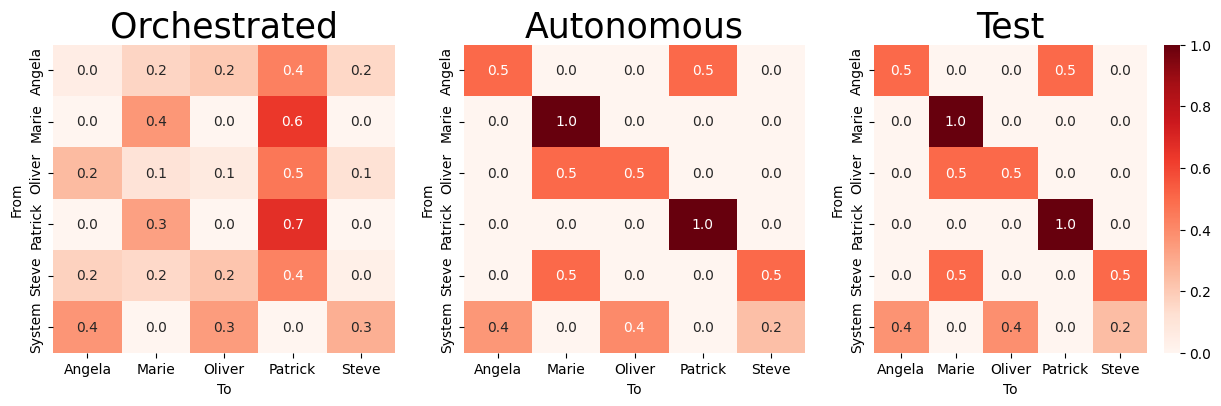

In [49]:
log_orch = pd.read_csv('../simulated_data/synthetic_log_calendars_2/orchestrated/simulated_log_0.csv')
log_auto = pd.read_csv('../simulated_data/synthetic_log_calendars_2/autonomous/simulated_log_0.csv')
log_test = pd.read_csv('../simulated_data/synthetic_log_calendars_2/orchestrated/test_preprocessed.csv')

resource_handover_heatmap_3([log_orch, log_auto, log_test])